## UPF Expeiments
    Feb2024

In [2]:

import os
import pandas as pd
import numpy as np
from sklearn.metrics import (accuracy_score, f1_score, precision_score, 
                             recall_score, roc_auc_score, mean_squared_error, r2_score)
from sklearn.model_selection import train_test_split
import xgboost as xgb
import math
import shap
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import matplotlib.pyplot as plt


from config import region_mapping, set1, to_model_a, to_model_c, to_model_ac, to_model, set10


path = '/Users/jerzybala/Desktop/Simulation Experiments Aug-Sep 2023/PROCESSED_FOOD_Dec2023.csv'

path_temp = '/Volumes/2TB Ext/BrainBaseMHQ/mhm_data_2024-02-03_17-00-42_from jan2023.csv'

path_temp_processed = '/Volumes/2TB Ext/BrainBaseMHQ/GMP_data_2023_to_jan2024.csv'

path1 = '/Users/jerzybala/Desktop/PROCESSED_FOOD_Dec2023.csv'


df = pd.read_csv(path1, low_memory=False)



df.loc[:, 'Processed food in diet'] = df['Processed food in diet'].replace({
            'Rarely/never': 'Rarely/Never',
            'A few times in a day': 'Several times a day',
            'Several days a week': 'A few times a week',
            'Many times in a day': 'Several times a day',
            'At least once a day': 'Several times a day'
        })


print(f"Data loaded. Shape: {df.shape}")

df_org=df.copy()



Data loaded. Shape: (401682, 238)


In [ ]:



mean_mhq_sign = df_org.groupby('Overall MHQ')['MHQ_Sign'].mean()


print(mean_mhq_sign)    





## Frequency feature numerical codding 

In [3]:


frequency_features = [
'Frequency of getting a good nights sleep',
'Frequency of doing exercise',
'Processed food in diet',
'Frequency of Socializing']

for f in frequency_features:
    print(f"{f}: {df[f].unique()}") 




df.loc[:, 'Frequency of getting a good nights sleep'] = df['Frequency of getting a good nights sleep'].replace({
    'Some of the time': 3,  # Occasional good sleep might be better than "Most days" depending on interpretation
    'Most of the time': 1,  # Most frequent good sleep
    'All of the time': 0,   # Always getting a good night's sleep
    'Hardly ever': 4,       # Rarely getting a good night's sleep
    'Most days': 2          # Assuming "Most days" is similar to "Some of the time", but could be adjusted based on interpretation
})


df.loc[:, 'Frequency of doing exercise'] = df['Frequency of doing exercise'].replace({
    'Less than once a week': 5,
    'Rarely/Never': 6,
    'Few days a week': 3,
    'Once a week': 4,
    'Every day': 1,
    'Some days of the week': 2, # Assuming this is less than "Every day" but more than "Few days a week"
    'Several days a week': 3    # Similar to "Few days a week"
})



df.loc[:, 'Processed food in diet'] = df['Processed food in diet'].replace({
    'A few times a week': 3,
    'Rarely/Never': 1,
    'A few times a month': 2,
    'Several times a day': 5,
    'Once a day': 4
})



df.loc[:, 'Frequency of Socializing'] = df['Frequency of Socializing'].replace({ 
    '1-3 times a month': 2,
    'Rarely/Never': 4,
    'Once a week': 3,
    'Several days a week': 1
})




Frequency of getting a good nights sleep: ['Some of the time' 'Most of the time' 'All of the time' 'Hardly ever'
 'Most days']
Frequency of doing exercise: ['Less than once a week' 'Rarely/Never' 'Few days a week' 'Once a week'
 'Every day' 'Some days of the week' 'Several days a week']
Processed food in diet: ['A few times a week' 'Rarely/Never' 'A few times a month'
 'Several times a day' 'Once a day']
Frequency of Socializing: ['1-3 times a month' 'Rarely/Never' 'Once a week' 'Several days a week']


In [ ]:
# Execute the following code to create a new dataframe with only the features of interest


## Function Definitions

In [4]:
def segment_and_prepare_df(df, countries=None, age_groups=None, drop_list=None):
    """
    Segments the DataFrame based on specific countries and age groups, and then drops specified columns.
    
    Parameters:
    - df: DataFrame to be processed.
    - countries: List of countries for segmentation. If None, no country-based segmentation is applied.
    - age_groups: List of age groups for segmentation. If None, no age-based segmentation is applied.
    - drop_list: List of columns to be dropped from the DataFrame.
    
    Returns:
    - A DataFrame that has been segmented and had specified columns dropped.
    """
    # Segment DataFrame based on provided countries and age groups
    segmented_df = df.copy()
    if countries is not None:
        segmented_df = segmented_df[segmented_df['Country'].isin(countries)]
    if age_groups is not None:
        segmented_df = segmented_df[segmented_df['Age'].isin(age_groups)]
    
    # Drop specified columns if drop_list is provided
    if drop_list is not None:
        segmented_df = segmented_df.drop(columns=drop_list)
    
    return segmented_df
#================================================================================================


def encode_features(df, categorical_features):
    """Encodes categorical features using one-hot encoding."""
    encoded_features = pd.get_dummies(df[categorical_features])
    return pd.concat([df.drop(columns=categorical_features), encoded_features], axis=1)
#================================================================================================


def prepare_dataset(df, target_classification, target_regression):
    """Prepares the dataset by dropping specified columns, encoding categorical features, and splitting into features and targets."""
    #df_filtered = drop_columns(df, drop_list)
    categorical_features = df.select_dtypes(include=['object']).columns
    df_filtered = encode_features(df, categorical_features)
    
    X = df_filtered.drop(columns=[target_classification, target_regression], axis=1)
    y_classification = df_filtered[target_classification]
    y_regression = df_filtered[target_regression]
    
    return X, y_classification, y_regression

#================================================================================================

def split_dataset(X, y_classification, y_regression, test_size=0.3, random_state=42):
    """Splits the dataset into training and testing sets for both classification and regression tasks."""
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=test_size, random_state=random_state)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg

#================================================================================================





## Selecting data with feature subset

In [5]:


df_features = df[set10].copy()


drop_list = [

    'Country',

    'Household Income',

    'ARCHIVED: Smartphone ownership',
    'ARCHIVED: Age of smartphone access',
    'Smartphone allowed in school',
    'Smartphone use in lessons',

    'Smartphone ownership',
    'Friends/classmates smarphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'

]

anglosphere = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland']
kraj = ['United States']
kraj2 =['India']
wiek = ['18-24', '21-24', '18', '19', '20']
wiek2 = ['55-64','45-54']


# Segment and prepare the DataFrame
prepared_df = segment_and_prepare_df(df_features, countries=None, age_groups=None, drop_list=drop_list)



# Features construcrs defined in config.py
# 'Legal_Substance_Use'
# 'Interpersonal_Trauma'
# 'Life_Adversities'


from config import Legal_Substance_Use, Interpersonal_Trauma, Life_Adversities


prepared_df['Legal_Substance_Use'] = prepared_df[Legal_Substance_Use].sum(axis=1)
prepared_df['Interpersonal_Trauma'] = prepared_df[Interpersonal_Trauma].sum(axis=1)
prepared_df['Life_Adversities'] = prepared_df[Life_Adversities].sum(axis=1)


prepared_df.to_csv('/Users/jerzybala/Desktop/prepared_df.csv', index=False)







prepared_df.shape

(401682, 49)

In [ ]:
prepared_df['MHQ_Sign'].value_counts()


## Feature Exploreation

In [ ]:
prepared_df.columns.to_list()

In [ ]:
# Include or not to include UPF

prepared_df=prepared_df.drop('Processed food in diet', axis=1)


In [ ]:
import numpy as np
from scipy.stats import entropy

def calculate_infogain(df, target):
    # Calculate the entropy of the target variable
    target_entropy = entropy(df[target].value_counts(normalize=True), base=2)
    
    # Calculate the entropy of each feature
    feature_entropies = []
    for column in df.columns:
        if column != target:
            feature_entropy = 0
            for value in df[column].unique():
                subset = df[df[column] == value]
                subset_entropy = entropy(subset[target].value_counts(normalize=True), base=2)
                feature_entropy += (len(subset) / len(df)) * subset_entropy
            feature_entropies.append(feature_entropy)
    
    # Calculate the information gain for each feature
    infogains = target_entropy - np.array(feature_entropies)
    
    # Create a dictionary mapping each feature to its information gain
    infogain_dict = dict(zip(df.columns[df.columns != target], infogains))
    
    return infogain_dict


In [ ]:
prepared_df_c =prepared_df.drop(columns='Overall MHQ', axis=1)


info_gained_features = calculate_infogain(prepared_df_c, 'MHQ_Sign')


In [ ]:
from tabulate import tabulate

def print_sorted_feature_scores(feature_scores, score_name="Score", table_format="grid"):
    """
    Sorts a dictionary of features and their scores in descending order and prints it in tabulated format.

    Parameters:
    - feature_scores: Dictionary with features as keys and scores as values.
    - score_name: A string representing the name of the score for the header. Defaults to "Score".
    - table_format: A string representing the table format to be used by tabulate. Defaults to "grid".
    """
    # Convert the dictionary to a list of tuples and sort it in descending order by score
    feature_scores_sorted = sorted(feature_scores.items(), key=lambda x: x[1], reverse=True)

    # Print the sorted list in tabulate format with customizable headers
    print(tabulate(feature_scores_sorted, headers=["Feature", score_name], tablefmt=table_format))

# Example usage for information gain:
print_sorted_feature_scores(info_gained_features, score_name="Information Gain")




In [ ]:
## Write to Excel

# Convert the dictionary to a DataFrame
features_ranks = pd.DataFrame(list(info_gained_features.items()), columns=['Feature', 'Information Gain'])

# Sort the DataFrame by 'Information Gain' in descending order
features_ranks_sorted = features_ranks.sort_values(by='Information Gain', ascending=False)

# Specify the file path (adjust the path as necessary for your system)
file_path = '/Users/jerzybala/Desktop/sapien_temp.xlsx'

# Write the sorted DataFrame to an Excel file
features_ranks_sorted.to_excel(file_path, index=False, engine='openpyxl')

print(f"Feature scores have been written to {file_path}")




In [ ]:
# File deletion

#  CAREFUL! This will delete the file at the specified path
# ******************************************************

# After ensuring the file is no longer needed, delete it
os.remove(file_path)
print(f"The file {file_path} has been deleted.")


In [ ]:

list1 = ['Interpersonal_Trauma', 'Age', 'Legal_Substance_Use', 'Life_Adversities']


for l in list1:
    a = prepared_df[l].unique().tolist()
    print(f"{l}: {a}, number of unique={len(a)}")   




##  Optional, run if needed


In [ ]:
prepared_df.to_csv('/Users/jerzybala/Desktop/prepared_df.csv', index=False)

In [ ]:
prepared_df['MHQ_Sign'] = prepared_df['MHQ_Sign'].replace({1: 0, 0: 1})

In [ ]:
import matplotlib.pyplot as plt

value_counts = prepared_df['MHQ_Sign'].value_counts()
plt.bar(value_counts.index.astype(int), value_counts.values)
plt.xticks([0, 1])

## MODELING

In [6]:
X, y_classification, y_regression = prepare_dataset(prepared_df, 'MHQ_Sign', 'Overall MHQ')

age_values = [
 'Age_18',
 'Age_18-24',
 'Age_19',
 'Age_20',
 'Age_21-24',
 'Age_25-34',
 'Age_35-44',
 'Age_45-54',
 'Age_55-64',
 'Age_65-74',
 'Age_75-84',
 'Age_85+']



#X = X.drop(columns=age_values, axis=1)   # if decided that 'Age' is not a feature

#X.columns.to_list()



X_train, X_test, y_train, y_test, X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_dataset(
    X, 
    y_classification, 
    y_regression, 
    test_size=0.4, 
    random_state=42
)



In [ ]:
X_test.shape



In [7]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix


par1 = {
    'n_estimators': 200, 
    'learning_rate': 0.01,
    'max_depth': 10, 
    'min_child_weight': 1, 
    'gamma': 0.01, 
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# Initialize XGBoost classifier and train

model_C = xgb.XGBClassifier(**par1)
model_C.fit(X_train, y_train)

# Predict and evaluate
predictions = model_C.predict(X_test)

accuracy = accuracy_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
auc = roc_auc_score(y_test, model_C.predict_proba(X_test)[:, 1])

print("xgb.XGBClassifier:")
print(f"Accuracy: {accuracy}")
print(f"F1 Score: {f1}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"AUC: {auc}")
print("\n")








#==================================================================================================


# Initialize XGBoost regressor and train
#model = xgb.XGBRegressor()
# X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=0.3, random_state=42)


#model_R = xgb.XGBRegressor()

model_R = xgb.XGBRegressor(
n_estimators=200,
learning_rate=0.1,
max_depth=6,
min_child_weight=1,
gamma=0.2,
subsample=0.4,
colsample_bytree=0.8,
#reg_alpha=10,
reg_lambda=0.1
)

model_R.fit(X_train_reg, y_train_reg)

# Separate predictions based on the sign of y_test
predictions = model_R.predict(X_test_reg)

mse = mean_squared_error(y_test_reg, predictions)
rmse = math.sqrt(mse)
r2 = r2_score(y_test_reg, predictions)
mae = mean_absolute_error(y_test_reg, predictions)

print("xgb.XGBRegressor:")
print('mae:', mae)
print('rmse:',rmse)
print('r2:', r2)
print("\n")



The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[21:51:17] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1637426411619/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
xgb.XGBClassifier:
Accuracy: 0.7925849395978167
F1 Score: 0.8724861489485444
Precision: 0.8080240395177922
Recall: 0.9481251715162452
AUC: 0.7948924904329495


xgb.XGBRegressor:
mae: 47.701325795017034
rmse: 58.64177627854928
r2: 0.3556958186510307




In [8]:
model_C

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8,
              enable_categorical=False, gamma=0.01, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.01, max_delta_step=0, max_depth=10,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=10, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0, reg_lambda=1,
              scale_pos_weight=1, subsample=0.8, tree_method='exact',
              validate_parameters=1, verbosity=None)

In [9]:
model_R

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0.2, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=200, n_jobs=10,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=0.1, scale_pos_weight=1, subsample=0.4,
             tree_method='exact', validate_parameters=1, verbosity=None)

## SHAP

In [ ]:
import shap

explainer_C = shap.Explainer(model_C)
shap_values_C = explainer_C(X_train)



In [ ]:
# Now use the shap.summary_plot with the subset of SHAP values and the corresponding X_train subset
shap.summary_plot(shap_values_C, X_train, plot_size=(16,10), max_display=30, show=False)


In [ ]:

frequency_features = [
'Frequency of getting a good nights sleep',
'Frequency of doing exercise',
'Processed food in diet',
'Frequency of Socializing']


feature_names = X_train.columns  # Adjust if your feature names are stored differently
desired_feature_indices = [i for i, feature in enumerate(feature_names) if feature in frequency_features]


# This assumes shap_values_C.values is a structured array or similar where the first dimension is samples and the second is features
subset_shap_values_array = shap_values_C.values[:, desired_feature_indices]



X_train_subset = X_train[frequency_features]

# Now use the shap.summary_plot with the subset of SHAP values and the corresponding X_train subset
shap.summary_plot(subset_shap_values_array, X_train_subset, plot_size=(16,10))

In [ ]:
plt.figure(figsize=(10, 5))
plt.hist(df_org['Processed food in diet'])
plt.show()

df['Processed food in diet'].isna().sum()





##  X_test / X_test_reg Change Simulation

In [10]:

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, confusion_matrix

def test_model_with_modified_X_test(X_test, y_test, model, values_to_change, replacement_value, percentage_change):
    # Make sure percentage_change is between 0 and 1
    if not 0 <= percentage_change <= 1:
        raise ValueError("percentage_change must be between 0 and 1.")
    
    # Make sure replacement value is not in values to change
    if replacement_value in values_to_change:
        raise ValueError("replacement_value should not be in values_to_change.")

    # Make a copy of X_test to avoid changing the original data
    X_test_modified = X_test.copy()

    # Iterate over the specified values to be changed
    for value in values_to_change:
        # Find the indices where 'Processed food in diet' equals the current value
        indices = X_test_modified[X_test_modified['Processed food in diet'] == value].index
        # Calculate how many entries to replace
        num_entries_to_replace = int(len(indices) * percentage_change)
        # Randomly select entries to replace
        indices_to_replace = np.random.choice(indices, size=num_entries_to_replace, replace=False)
        # Replace the selected entries with the replacement value
        X_test_modified.loc[indices_to_replace, 'Processed food in diet'] = replacement_value

    # Predict with the modified X_test
    predictions_proba = model.predict_proba(X_test_modified)
    predictions = np.argmax(predictions_proba, axis=1)

    # Calculate evaluation metrics
    accuracy = accuracy_score(y_test, predictions)
    f1 = f1_score(y_test, predictions)
    precision = precision_score(y_test, predictions)
    recall = recall_score(y_test, predictions)
    auc = roc_auc_score(y_test, predictions_proba[:, 1])
    
    # Calculate specificity (true negative rate)
    tn, fp, _, _ = confusion_matrix(y_test, predictions).ravel()
    specificity = tn / (tn + fp)

    # Output results
    print("xgb.XGBClassifier results with modified X_test:")
    print(f"Accuracy: {accuracy}")
    print(f"F1 Score: {f1}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"Specificity: {specificity}")
    print(f"AUC: {auc}")
    print("\nPredicted Probabilities for each data point:\n", predictions_proba)

    return accuracy, f1, precision, recall, specificity, auc, predictions_proba, X_test_modified

# You can use this function as before, now with specificity included in the output.

#****************************************************************************************************



def test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model, values_to_change, replacement_value, percentage_change):
    # Ensure percentage_change is between 0 and 1
    if not 0 <= percentage_change <= 1:
        raise ValueError("percentage_change must be between 0 and 1.")
    
    # Ensure replacement value is not in values to change
    if replacement_value in values_to_change:
        raise ValueError("replacement_value should not be in values_to_change.")

    # Make a copy of X_test_reg to avoid changing the original data
    X_test_modified = X_test_reg.copy()

    # Iterate over the specified values to be changed
    for value in values_to_change:
        # Find the indices where the feature equals the current value
        # Replace 'ProcessedFoodInDiet' with the actual feature name you are modifying
        indices = X_test_modified[X_test_modified['Processed food in diet'] == value].index
        num_entries_to_replace = int(len(indices) * percentage_change)
        indices_to_replace = np.random.choice(indices, size=num_entries_to_replace, replace=False)
        X_test_modified.loc[indices_to_replace, 'Processed food in diet'] = replacement_value

    # Predict with the modified X_test_reg
    predictions = model.predict(X_test_modified)

    # Calculate evaluation metrics
    mse = mean_squared_error(y_test_reg, predictions)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test_reg, predictions)
    mae = mean_absolute_error(y_test_reg, predictions)

    # Output results
    print("xgb.XGBRegressor results with modified X_test_reg:")
    print('Mean Absolute Error:', mae)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', r2)

    return mae, rmse, r2, predictions, X_test_modified









xgb.XGBClassifier results with modified X_test:
Accuracy: 0.7880477740504005
F1 Score: 0.8714124430314266
Precision: 0.7980745290065565
Recall: 0.9595928516186976
Specificity: 0.27772005343624756
AUC: 0.7911578499259816

Predicted Probabilities for each data point:
 [[0.19482636 0.80517364]
 [0.17375141 0.8262486 ]
 [0.36569142 0.6343086 ]
 ...
 [0.4907313  0.5092687 ]
 [0.3557124  0.6442876 ]
 [0.12198555 0.87801445]]
xgb.XGBClassifier results with modified X_test:
Accuracy: 0.7925849395978167
F1 Score: 0.8724861489485444
Precision: 0.8080240395177922
Recall: 0.9481251715162452
Specificity: 0.3298698728415219
AUC: 0.7948924904329495

Predicted Probabilities for each data point:
 [[0.19307584 0.80692416]
 [0.17375141 0.8262486 ]
 [0.4014817  0.5985183 ]
 ...
 [0.4907313  0.5092687 ]
 [0.3557124  0.6442876 ]
 [0.12198555 0.87801445]]
xgb.XGBClassifier results with modified X_test:
Accuracy: 0.7902198875977918
F1 Score: 0.8719960504329333
Precision: 0.8024589533721491
Recall: 0.954728027

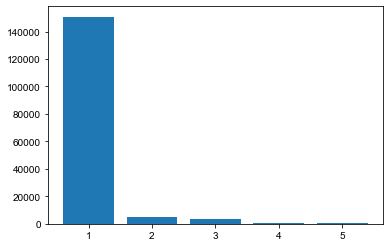

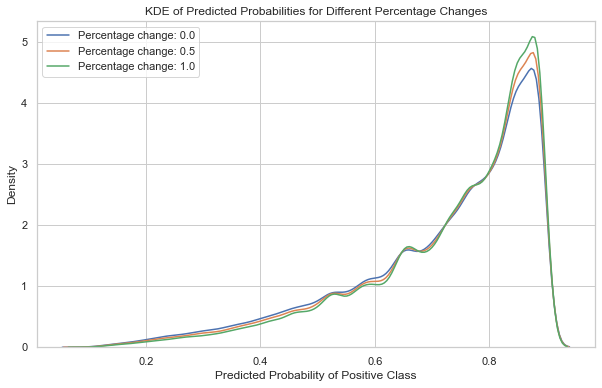

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt


#     'A few times a week': 3,
#     'Rarely/Never': 1,
#     'A few times a month': 2,
#     'Several times a day': 5,
#     'Once a day': 4



# Example usage:
values_to_change = [2, 3, 4, 5]
replacement_value = 1
#test_model_with_modified_X_test(X_test, y_test, model_C, values_to_change, replacement_value, 0.1)


accuracy, f1, precision, recall, specificity, auc, predictions_proba, X_test_modified = test_model_with_modified_X_test(X_test, y_test, model_C, values_to_change, replacement_value, 0.9)

X_test_modified['Processed food in diet'].value_counts(normalize=True)

plt.bar(X_test_modified['Processed food in diet'].value_counts().index, X_test_modified['Processed food in diet'].value_counts().values)    





# def plot_prediction_proba_distribution(predictions_proba, positive_class_column=1):
#     # Extract the probabilities for the positive class
#     positive_class_probs = predictions_proba[:, positive_class_column]

#     # Create the plot
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(10, 6))
#     sns.distplot(positive_class_probs, kde=True, color="blue", hist=True, norm_hist=True)
#     plt.title('Distribution of Predicted Probabilities for the Positive Class')
#     plt.xlabel('Predicted Probability of Positive Class')
#     plt.ylabel('Density')
#     plt.show()


# def plot_prediction_proba_distribution(predictions_proba, positive_class_column=1):
#     # Extract the probabilities for the positive class
#     positive_class_probs = predictions_proba[:, positive_class_column]

#     # Create the plot
#     sns.set(style="whitegrid")
#     plt.figure(figsize=(10, 6))
#     sns.distplot(positive_class_probs, kde=True, color="blue", hist=False)
#     plt.title('Distribution of Predicted Probabilities for the Positive Class')
#     plt.xlabel('Predicted Probability of Positive Class')
#     plt.ylabel('Density')
#     plt.show()




def plot_combined_proba_distributions(proba_dict):
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Plot the KDE for each percentage_change's predicted probabilities
    for per, predictions_proba in proba_dict.items():
        positive_class_probs = predictions_proba[:, 1]  # Assuming positive class is the second column
        sns.kdeplot(positive_class_probs, label=f'Percentage change: {per}', shade=False)
    
    plt.title('KDE of Predicted Probabilities for Different Percentage Changes')
    plt.xlabel('Predicted Probability of Positive Class')
    plt.ylabel('Density')
    plt.legend()
    plt.show()





# # Example usage:
# # predictions_proba is assumed to be obtained from the test_model_with_modified_X_test function
# plot_prediction_proba_distribution(predictions_proba)


# for per in [0.0, 1.0, 0.01]:
#     accuracy, f1, precision, recall, specificity, auc, predictions_proba, X_test_modified = test_model_with_modified_X_test(
#         X_test, y_test, model_C, values_to_change, replacement_value, per)
#     plot_prediction_proba_distribution(predictions_proba)
    

#Usage:
# Store the predicted probabilities in a dictionary with percentage_change as keys
proba_dict = {}
for per in [0.0, 0.5, 1.0]:
    _, _, _, _, _, _, predictions_proba, _ = test_model_with_modified_X_test(
        X_test, y_test, model_C, values_to_change, replacement_value, per)
    proba_dict[per] = predictions_proba


# Plot all KDEs on the same figure
plot_combined_proba_distributions(proba_dict)




xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 47.701325795017034
Root Mean Squared Error: 58.64177627854928
R-squared: 0.3556958186510307
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 47.87948987716023
Root Mean Squared Error: 59.017292714996756
R-squared: 0.347417710904107
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 48.08613861812565
Root Mean Squared Error: 59.410893698419834
R-squared: 0.33868421803907867


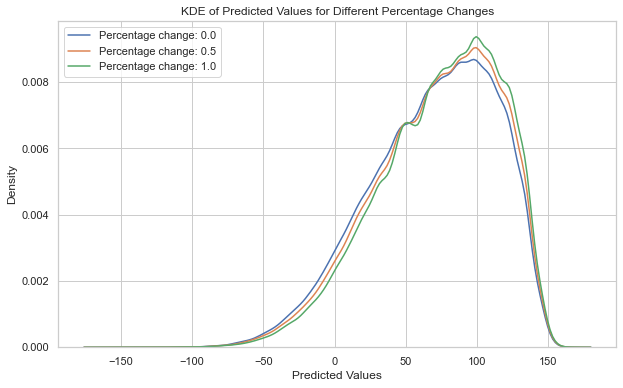

In [12]:

import seaborn as sns
import matplotlib.pyplot as plt




def plot_combined_prediction_distributions(prediction_dict):
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Plot the KDE for each percentage_change's predictions
    for per, predictions in prediction_dict.items():
        sns.kdeplot(predictions, label=f'Percentage change: {per}', shade=False)
    
    plt.title('KDE of Predicted Values for Different Percentage Changes')
    plt.xlabel('Predicted Values')
    plt.ylabel('Density')
    plt.legend()
    plt.show()

# Usage:
# Store the regression predictions in a dictionary with percentage_change as keys
    

# Example usage:
values_to_change = [2, 3, 4, 5]
replacement_value = 1



prediction_dict = {}
for per in [0.0, 0.5, 1.0]:
    mae, rmse, r2, predictions, X_test_modified = test_regressor_with_modified_X_test(
        X_test_reg, y_test_reg, model_R, values_to_change, replacement_value, per)
    prediction_dict[per] = predictions

# Plot all KDEs on the same figure
plot_combined_prediction_distributions(prediction_dict)








In [60]:
model_R

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.2, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=6, max_leaves=None,
             min_child_weight=1, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=200, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 47.701325795017034
Root Mean Squared Error: 58.64177627854928
R-squared: 0.3556958186510307
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 47.76150548316623
Root Mean Squared Error: 58.781749204559055
R-squared: 0.35261634939344444
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 47.89625587093188
Root Mean Squared Error: 59.03014173305384
R-squared: 0.3471335245576972
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 48.0146811891578
Root Mean Squared Error: 59.26795861177458
R-squared: 0.3418624742426928
xgb.XGBRegressor results with modified X_test_reg:
Mean Absolute Error: 48.08613861812565
Root Mean Squared Error: 59.410893698419834
R-squared: 0.33868421803907867


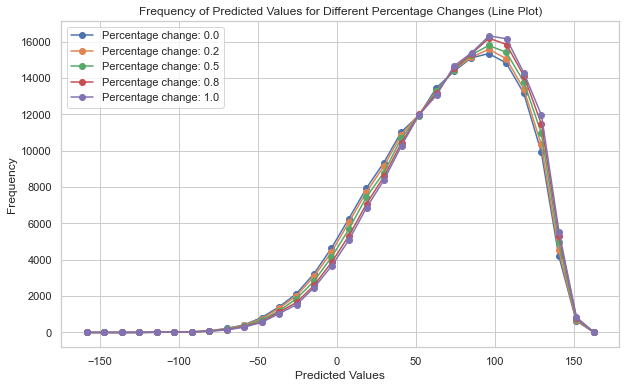

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_prediction_frequencies_line(prediction_dict, bins=100):
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Calculate and plot the frequencies as lines for each percentage_change's predictions
    for per, predictions in prediction_dict.items():
        counts, bin_edges = np.histogram(predictions, bins=bins)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts, label=f'Percentage change: {per}', marker='o', linestyle='-')
    
    plt.title('Frequency of Predicted Values for Different Percentage Changes (Line Plot)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

# Example usage:
values_to_change = [2, 3, 4, 5]
replacement_value = 1

prediction_dict = {}
for per in [0.0, 0.2, 0.5, 0.8, 1.0]:
    mae, rmse, r2, predictions, X_test_modified = test_regressor_with_modified_X_test(
        X_test_reg, y_test_reg, model_R, values_to_change, replacement_value, per)
    prediction_dict[per] = predictions

# Plot frequency lines on the same figure
plot_combined_prediction_frequencies_line(prediction_dict, bins=30)


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_prediction_differences_line(prediction_dict, bins=100):
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 8))
    
    # Calculate the baseline histogram for per=0.0
    baseline_counts, baseline_bin_edges = np.histogram(prediction_dict[0.0], bins=bins)
    baseline_bin_centers = (baseline_bin_edges[:-1] + baseline_bin_edges[1:]) / 2
    
    # Plot differences for each percentage_change's predictions compared to the baseline
    for per, predictions in prediction_dict.items():
        if per == 0.0:  # Skip the baseline itself
            continue
        counts, bin_edges = np.histogram(predictions, bins=bins)
        # Ensure same bins for all histograms by using the baseline bin edges
        counts_aligned, _ = np.histogram(predictions, bins=baseline_bin_edges)
        differences = counts_aligned - baseline_counts
        plt.plot(baseline_bin_centers, differences, label=f'Percentage change: {per}', marker='o', linestyle='-')
    
    plt.title('Difference in Frequency of Predicted Values Compared to Baseline (per=0.0)')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency Difference')
    plt.legend()
    plt.show()


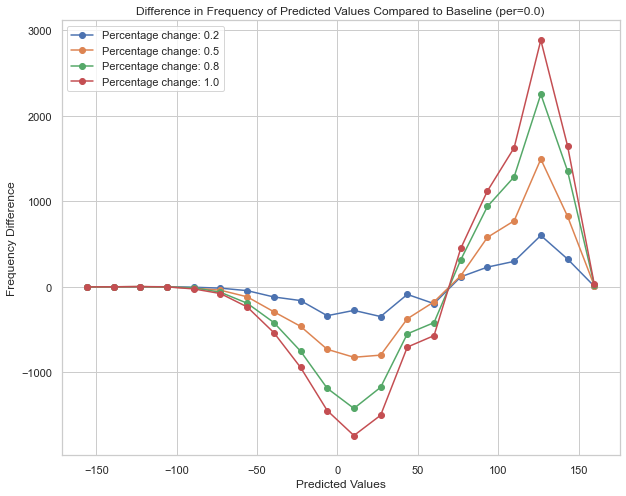

In [32]:
plot_combined_prediction_differences_line(prediction_dict, bins=20)


In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_prediction_differences_line(prediction_dict, bins=100):
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Calculate the baseline histogram for per=0.0
    baseline_counts, baseline_bin_edges = np.histogram(prediction_dict[0.0], bins=bins)
    baseline_bin_centers = (baseline_bin_edges[:-1] + baseline_bin_edges[1:]) / 2
    
    # Plot differences for each percentage_change's predictions compared to the baseline
    for per, predictions in prediction_dict.items():
        if per == 0.0:  # Skip the baseline itself
            continue
        counts, bin_edges = np.histogram(predictions, bins=bins)
        # Ensure same bins for all histograms by using the baseline bin edges
        counts_aligned, _ = np.histogram(predictions, bins=baseline_bin_edges)
        differences = counts_aligned - baseline_counts
        # Format the label to display percentages
        percentage_label = f'{per*100}% change' if per != 0 else 'Baseline'
        plt.plot(baseline_bin_centers, differences, label=percentage_label, marker='o', linestyle='-')
    
    plt.title('Difference in Frequency of Predicted Values Compared to Baseline')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency Difference')
    plt.legend()
    plt.show()


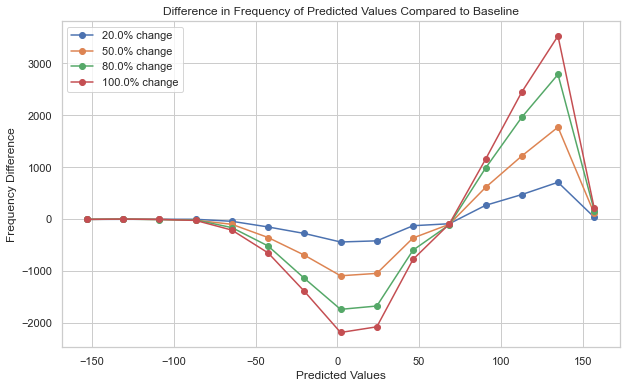

In [36]:
plot_combined_prediction_differences_line(prediction_dict, bins=15)

In [38]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_combined_prediction_differences_percentage_line(prediction_dict, bins=100, total_X_test=None):
    # Check if total_X_test is provided
    if total_X_test is None:
        raise ValueError("Total number of observations in X_test must be provided.")
    
    # Set up the plot
    sns.set(style="whitegrid")
    plt.figure(figsize=(10, 6))
    
    # Calculate the baseline histogram for per=0.0
    baseline_counts, baseline_bin_edges = np.histogram(prediction_dict[0.0], bins=bins)
    baseline_bin_centers = (baseline_bin_edges[:-1] + baseline_bin_edges[1:]) / 2
    
    # Plot differences for each percentage_change's predictions compared to the baseline
    for per, predictions in prediction_dict.items():
        if per == 0.0:  # Skip the baseline itself
            continue
        counts, bin_edges = np.histogram(predictions, bins=bins)
        # Ensure same bins for all histograms by using the baseline bin edges
        counts_aligned, _ = np.histogram(predictions, bins=baseline_bin_edges)
        differences = counts_aligned - baseline_counts
        # Convert differences to percentage of total X_test
        differences_percentage = (differences / total_X_test) * 100
        percentage_label = f'{per*100}% change' if per != 0 else 'Baseline'
        plt.plot(baseline_bin_centers, differences_percentage, label=percentage_label, marker='o', linestyle='-')
    
    plt.title('Percentage Difference in Frequency of Predicted Values Compared to Baseline')
    plt.xlabel('Predicted Values')
    plt.ylabel('Frequency Difference (%) of Total X_test')
    plt.legend()
    plt.show()


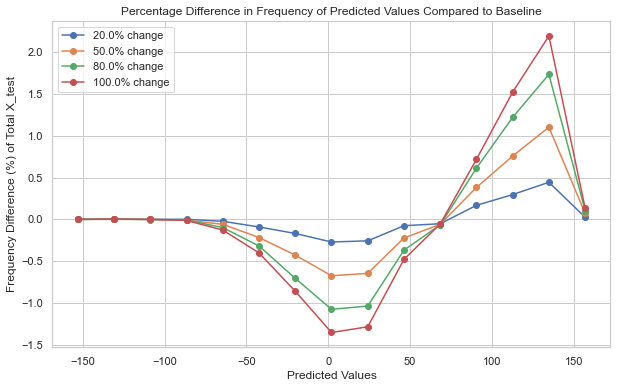

In [40]:
total_X_test = len(X_test)  # Assuming X_test is available and represents your test dataset
plot_combined_prediction_differences_percentage_line(prediction_dict, bins=15, total_X_test=total_X_test)


## Plot for % chanage from 0 to 100 

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def evaluate_and_plot_metrics(X_test, y_test, model, values_to_change, replacement_value, metrics_to_plot):
    # Define the range of percentage changes to evaluate
    percentage_changes = np.arange(0, 1.1, 0.1)
    
    # Initialize a dictionary to store the metrics for each percentage change
    performance_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'specificity': [],
        'auc': []
    }
    
    # Evaluate the model for each percentage change
    for pc in percentage_changes:
        # Use the provided test_model_with_modified_X_test function
        acc, f1, prec, rec, spec, auc, _, _ = test_model_with_modified_X_test(
            X_test, y_test, model, values_to_change, replacement_value, pc)
        
        # Store the metrics in the dictionary
        performance_metrics['accuracy'].append(acc)
        performance_metrics['f1'].append(f1)
        performance_metrics['precision'].append(prec)
        performance_metrics['recall'].append(rec)
        performance_metrics['specificity'].append(spec)
        performance_metrics['auc'].append(auc)

    # Plot the specified metrics
    plt.figure(figsize=(12, 8))
    for metric in metrics_to_plot:
        plt.plot(percentage_changes, performance_metrics[metric], marker='o', label=f'{metric.title()}')

    plt.title(f'Model Performance vs. Percentage Change')
    plt.xlabel('Percentage Change')
    plt.ylabel(metrics_to_plot)
    plt.xticks(percentage_changes)
    plt.legend()
    plt.grid(True)
    plt.show()

    return performance_metrics

# Example usage of the function:
# metrics = evaluate_and_plot_metrics(X_test, y_test, model, [2, 3, 4, 5], 1, metrics_to_plot=['accuracy', 'recall', 'specificity'])


In [ ]:
#     'A few times a week': 3,
#     'Rarely/Never': 1,
#     'A few times a month': 2,
#     'Several times a day': 5,
#     'Once a day': 4



# Example usage:
values_to_change = [2,3,4,5]
replacement_value = 1

evaluate_and_plot_metrics(X_test, y_test, model_C, values_to_change, replacement_value,  metrics_to_plot=['recall'])
                                                                                                          


In [ ]:
import numpy as np
import xgboost as xgb
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import math

def test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model, percentage_change):
    # Make sure percentage_change is between 0 and 1
    if not 0 <= percentage_change <= 1:
        raise ValueError("percentage_change must be between 0 and 1.")
    
    # Make a copy of X_test_reg to avoid changing the original data
    X_test_modified = X_test_reg.copy()

    # Iterate over the unique values except 5
    for value in [1, 2, 3, 4]:
        # Find the indices where 'Processed food in diet' equals the current value
        indices = X_test_modified[X_test_modified['Processed food in diet'] == value].index
        # Calculate how many entries to replace
        num_entries_to_replace = int(len(indices) * percentage_change)
        # Randomly select entries to replace
        indices_to_replace = np.random.choice(indices, size=num_entries_to_replace, replace=False)
        # Replace the selected entries with 5
        X_test_modified.loc[indices_to_replace, 'Processed food in diet'] = 5

    # Predict with the modified X_test_reg
    predictions = model.predict(X_test_modified)

    # Evaluation
    mse = mean_squared_error(y_test_reg, predictions)
    rmse = math.sqrt(mse)
    r2 = r2_score(y_test_reg, predictions)
    mae = mean_absolute_error(y_test_reg, predictions)

    # Output results
    print("xgb.XGBRegressor results with modified X_test_reg:")
    print('Mean Absolute Error:', mae)
    print('Root Mean Squared Error:', rmse)
    print('R-squared:', r2)
    print("\nPredicted Values for each data point:\n", predictions)

    return mae, rmse, r2, predictions


In [ ]:
test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model_R, 0)

In [ ]:
mae, rmse, r2, predictions =test_regressor_with_modified_X_test(X_test_reg, y_test_reg, model_R, 0.5)

In [ ]:
import matplotlib.pyplot as plt

def plot_actual_vs_predicted(y_test_reg, predictions):
    plt.figure(figsize=(10, 6))
    plt.scatter(y_test_reg, predictions, alpha=0.3)
    plt.title('Actual vs. Predicted Values')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.plot([y_test_reg.min(), y_test_reg.max()], [y_test_reg.min(), y_test_reg.max()], 'k--', lw=4)
    plt.show()

# Assuming y_test_reg and predictions are already defined
# plot_actual_vs_predicted(y_test_reg, predictions)


In [ ]:
# Assuming y_test_reg and predictions are already defined
plot_actual_vs_predicted(y_test_reg, predictions)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

def evaluate_and_plot_metrics(X_test, y_test, model, values_to_change, replacement_value, metric='accuracy'):
    # Define the range of percentage changes to evaluate
    percentage_changes = np.arange(0, 1.1, 0.1)
    
    # Initialize a dictionary to store the metrics for each percentage change
    performance_metrics = {
        'accuracy': [],
        'f1': [],
        'precision': [],
        'recall': [],
        'auc': []
    }
    
    # Evaluate the model for each percentage change
    for pc in percentage_changes:
        # Use the provided test_model_with_modified_X_test function
        acc, f1, prec, rec, auc, _, _ = test_model_with_modified_X_test(
            X_test, y_test, model, values_to_change, replacement_value, pc)
        
        # Store the metrics in the dictionary
        performance_metrics['accuracy'].append(acc)
        performance_metrics['f1'].append(f1)
        performance_metrics['precision'].append(prec)
        performance_metrics['recall'].append(rec)
        performance_metrics['auc'].append(auc)

    # Plot the specified metric
    plt.figure(figsize=(10, 6))
    plt.plot(percentage_changes, performance_metrics[metric], marker='o')
    
    plt.title(f'Model {metric.title()} vs. Percentage Change')
    plt.xlabel('Percentage Change')
    plt.ylabel(f'{metric.title()} Score')
    plt.xticks(percentage_changes)
    plt.grid(True)
    plt.show()

    return performance_metrics

# Example usage of the function:
# metrics = evaluate_and_plot_metrics(X_test, y_test, model, [2, 3, 4, 5], 1, metric='accuracy')


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_histogram_with_averages(predictions, num_bins=20):
    # Calculate histogram data
    counts, bin_edges = np.histogram(predictions, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate the average prediction per bin
    averages = [predictions[(predictions >= bin_edges[i]) & (predictions < bin_edges[i+1])].mean() for i in range(num_bins)]
    
    # Plot the histogram
    plt.figure(figsize=(12, 6))
    plt.hist(predictions, bins=num_bins, alpha=0.5, label='Frequency')
    
    # Plot the average line per bin
    plt.scatter(bin_centers, averages, color='red', label='Bin Averages')
    
    # Add a line representing the overall average
    overall_avg = np.mean(predictions)
    plt.axhline(overall_avg, color='green', linestyle='dashed', linewidth=2, label=f'Overall Average: {overall_avg:.2f}')
    
    # Add labels and title
    plt.title('Histogram of Predicted Values with Bin Averages')
    plt.xlabel('Predicted Value')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()




In [ ]:
# Assuming 'predictions' is already defined
plot_histogram_with_averages(predictions)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_line_graph_of_bin_averages(predictions, num_bins=10):
    # Calculate histogram data to determine bin edges
    _, bin_edges = np.histogram(predictions, bins=num_bins)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Calculate the average prediction per bin
    bin_averages = [np.mean(predictions[(predictions >= bin_edges[i]) & (predictions < bin_edges[i+1])]) for i in range(len(bin_centers))]

    # Plot the line graph of averages
    plt.figure(figsize=(12, 6))
    plt.plot(bin_centers, bin_averages, 'o-', color='red', label='Average Predicted Value')
    
    # Add labels and title
    plt.title('Average Predicted Values per Bin')
    plt.xlabel('Predicted Value Bins')
    plt.ylabel('Average Predicted Value')
    plt.legend()
    plt.grid(True)
    plt.show()




In [ ]:
#Assuming 'predictions' is already defined
plot_line_graph_of_bin_averages(predictions)

In [ ]:
X_test_modified.columns.to_list()

# TEMP

In [ ]:
def segment_and_prepare_df(df, countries=None, age_groups=None, drop_list=None):
    """
    Segments the DataFrame based on specific countries and age groups, and then drops specified columns.
    
    Parameters:
    - df: DataFrame to be processed.
    - countries: List of countries for segmentation. If None, no country-based segmentation is applied.
    - age_groups: List of age groups for segmentation. If None, no age-based segmentation is applied.
    - drop_list: List of columns to be dropped from the DataFrame.
    
    Returns:
    - A DataFrame that has been segmented and had specified columns dropped.
    """
    # Segment DataFrame based on provided countries and age groups
    segmented_df = df.copy()
    if countries is not None:
        segmented_df = segmented_df[segmented_df['Country'].isin(countries)]
    if age_groups is not None:
        segmented_df = segmented_df[segmented_df['Age'].isin(age_groups)]
    
    # Drop specified columns if drop_list is provided
    if drop_list is not None:
        segmented_df = segmented_df.drop(columns=drop_list)
    
    return segmented_df




In [ ]:
# Assuming df is your initial dataframe
countries = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland', 'South Africa']
age_groups = ['18-24', '21-24', '18', '19', '20']
drop_list = [
    'Country',
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'
]

# Segment and prepare the DataFrame
prepared_df = segment_and_prepare_df(df, countries=countries, age_groups=age_groups, drop_list=drop_list)

# Continue with further data preparation steps as needed

In [ ]:
def prepare_dataset(df, drop_list, target_classification, target_regression):
    """Prepares the dataset by dropping specified columns, encoding categorical features, and splitting into features and targets."""
    df_filtered = drop_columns(df, drop_list)
    categorical_features = df_filtered.select_dtypes(include=['object']).columns
    df_filtered = encode_features(df_filtered, categorical_features)
    
    X = df_filtered.drop(columns=[target_classification, target_regression], axis=1)
    y_classification = df_filtered[target_classification]
    y_regression = df_filtered[target_regression]
    
    return X, y_classification, y_regression

def split_dataset(X, y_classification, y_regression, test_size=0.3, random_state=42):
    """Splits the dataset into training and testing sets for both classification and regression tasks."""
    X_train, X_test, y_train_class, y_test_class = train_test_split(X, y_classification, test_size=test_size, random_state=random_state)
    X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X, y_regression, test_size=test_size, random_state=random_state)
    
    return X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg





In [ ]:
# Example of how to use these functions
drop_list = [
    'Country',
    'Smartphone ownership',
    'Friends/classmates smartphone ownership',
    'Age of smartphone usage during school hours',
    'Smartphone usage during class hours',
    'Smartphone usage during break'
]

# Assuming df is your initial dataframe
X, y_classification, y_regression = prepare_dataset(df, drop_list, 'MHQ_Sign', 'Overall MHQ')
X_train, X_test, y_train_class, y_test_class, X_train_reg, X_test_reg, y_train_reg, y_test_reg = split_dataset(X, y_classification, y_regression)

In [ ]:



df_processed = df[set10].copy()

df_processed.loc[:, 'Processed food in diet'] = df_processed['Processed food in diet'].replace({
            'Rarely/never': 'Rarely/Never',
            'A few times in a day': 'Several times a day',
            'Several days a week': 'A few times a week',
            'Many times in a day': 'Several times a day',
            'At least once a day': 'Several times a day',
            'None of the above': 'None of the above SU'
        })




# Filter the encoded dataframe
anglosphere = ['United States', 'United Kingdom', 'Canada', 'Australia', 'New Zealand', 'Ireland']


kraj = ['United States']
kraj2 =['India']
        

wiek = ['18-24', '21-24', '18', '19', '20']
wiek2 = ['55-64','45-54']


#df_filtered = df_processed[(df_processed['Country'].isin(kraj)) & (df_processed['Age'].isin(wiek))]


#(2)
#df_filtered = df_processed[(df_processed['Country'].isin(anglosphere))]

#(1)
#df_filtered = df_processed.copy()


#(3) 
#df_filtered = df_processed[(df_processed['Country'].isin(kraj))]


#4 & 5#
#df_filtered = df_processed[(df_processed['Country'].isin(kraj)) & (df_processed['Age'].isin(wiek))]



#df_filtered = df_processed[(df_processed['Age'].isin(wiek2))]



df_filtered.shape